# Build  spectra for AuxTel

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : March 30th 2021
- creation update : March 31th 2021
- version v0


This notebook is to help for finding the position of order 0

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
from iminuit import Minuit
import iminuit

In [3]:
iminuit.__version__

'2.2.0'

In [4]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.images import *
from scipy import ndimage, misc

In [5]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

# Function

In [6]:
def file_target(filename):
    m=re.findall('^Cor_holo4_003_.*_(.*)_[0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*[.]fits$',filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []

# Logbook for file selection

In [7]:
filename_logbook='logbooks/auxtellogbook_2021_v1.csv'

In [8]:
df=pd.read_csv(filename_logbook,index_col=0)

In [9]:
pd.set_option('display.max_rows', None)

In [10]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,focus,seeing,pressure,temperature,humidity,windspd
0,0,2021-02-17T01:45:09.091,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_RG610_HD50896_2021-02-16_181.fits,181,HD50896,RG610,holo4_003,1.006209,90.0,-0.034843,NaN,743.10,10.3,51.0,9.3
1,1,2021-02-17T03:37:12.647,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_empty_HD50896_2021-02-16_209.fits,209,HD50896,empty_1,holo4_003,1.099905,90.0,0.000000,NaN,742.80,10.4,45.0,9.9
2,2,2021-02-18T07:25:02.387,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_350.fits,350,NGC4755,empty_1,holo4_003,1.158253,6.0,0.000000,NaN,742.30,8.8,53.0,7.3
3,3,2021-02-18T07:25:46.560,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_351.fits,351,NGC4755,empty_1,holo4_003,1.158097,6.0,0.000000,NaN,742.30,8.8,54.0,6.3
4,4,2021-02-18T07:26:07.146,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_352.fits,352,NGC4755,empty_1,holo4_003,1.158027,6.0,0.000000,NaN,742.30,8.8,54.0,6.3
5,5,2021-02-18T07:26:18.957,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_353.fits,353,NGC4755,empty_1,holo4_003,1.157987,6.0,0.000000,NaN,742.30,8.8,55.0,7.7
6,6,2021-02-18T07:26:43.049,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_354.fits,354,NGC4755,empty_1,holo4_003,1.157907,6.0,0.000000,NaN,742.30,8.8,55.0,7.7
7,7,2021-02-18T07:26:51.615,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_355.fits,355,NGC4755,empty_1,holo4_003,1.157879,6.0,0.000000,NaN,742.30,8.8,55.0,7.7
8,8,2021-02-18T07:27:00.190,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_356.fits,356,NGC4755,empty_1,holo4_003,1.157851,6.0,0.000000,NaN,742.30,8.8,55.0,7.7
9,9,2021-02-18T07:27:53.863,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_357.fits,357,NGC4755,empty_1,holo4_003,1.157723,6.0,0.000000,NaN,742.25,8.7,55.0,6.7


# Selection of input file

In [11]:
dir_spectra="/Users/dagoret/DATA/AuxTelData2021/holo/FlipCleans"

In [12]:
#filename_image="Cor_holo4_003_RG610_HD75519_2021-03-11_296.fits"

In [13]:
# 2021/03/31
#filename_image=df['file'][37] # 'Cor_holo4_003_empty_HD60753_2021-02-18_583.fits' reconstruit à moitié
#filename_image=df['file'][48] # 'Cor_holo4_003_RG610_HR3439_2021-03-11_165.fits'
#filename_image=df['file'][50] # 'Cor_holo4_003_RG610_HR3439_2021-03-11_167.fits'
#filename_image=df['file'][54] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_283.fits'
#filename_image=df['file'][55] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_284.fits' BAD image
#filename_image=df['file'][56] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_285.fits' BOUGE
#filename_image=df['file'][57] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_286.fits' BOUGE
#filename_image=df['file'][58] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_287.fits' BOUGE
#filename_image=df['file'][59] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_288.fits' BOUGE
#filename_image=df['file'][60] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_289.fits' BOUGE
#filename_image=df['file'][61] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_290.fits' PLANTE
#filename_image=df['file'][62] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_291.fits' BAD PSF
#filename_image=df['file'][63] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_292.fits' GOOD
#filename_image=df['file'][64] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_293.fits' GOOD
#filename_image=df['file'][65] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_294.fits' GOOD
#filename_image=df['file'][66] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_295.fits' GOOD
#filename_image=df['file'][67] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_296.fits' GOOD
#filename_image=df['file'][68] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_297.fits' BAD PSF
#filename_image=df['file'][69] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_298.fits' BAD PSF
#filename_image=df['file'][70] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_299.fits' BAD PSF
#filename_image=df['file'][71] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_300.fits' BAD PSF
#filename_image=df['file'][72] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_301.fits' PLANTE
#filename_image=df['file'][73] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_302.fits' PLANTE
#filename_image=df['file'][74] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_303.fits' BAD FOCUS
#filename_image=df['file'][75] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_304.fits' BAD FOCUS

# 2021/04/01

#filename_image=df['file'][2] # 'Cor_holo4_003_NGC4755_2021-02-17_350.fits'  GOOD PSF
#filename_image=df['file'][3] # 'Cor_holo4_003_NGC4755_2021-02-17_351.fits'  GOOD PSF
#filename_image=df['file'][4] # 'Cor_holo4_003_NGC4755_2021-02-17_352.fits'  GOOD PSF
#filename_image=df['file'][5] # 'Cor_holo4_003_NGC4755_2021-02-17_353.fits'  GOOD PSF
#filename_image=df['file'][6] # 'Cor_holo4_003_NGC4755_2021-02-17_354.fits'  GOOD PSF
#filename_image=df['file'][7] # 'Cor_holo4_003_NGC4755_2021-02-17_355.fits'  GOOD PSF
#filename_image=df['file'][8] # 'Cor_holo4_003_NGC4755_2021-02-17_356.fits'  GOOD PSF
#filename_image=df['file'][9] # 'Cor_holo4_003_NGC4755_2021-02-17_357.fits'  GOOD PSF
#filename_image=df['file'][10] # 'Cor_holo4_003_NGC4755_2021-02-17_358.fits'  GOOD PSF
#filename_image=df['file'][11] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_556.fits'  GOOD PSF
#filename_image=df['file'][12] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_557.fits'  defocused, failed
#filename_image=df['file'][13] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_558.fits'  defocused, failed
#filename_image=df['file'][14] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_559.fits'  good, but central star
#filename_image=df['file'][15] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_560.fits'  bad psf, but looks good
#filename_image=df['file'][16] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_561.fits'  Very good
#filename_image=df['file'][17] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_562.fits'  Very good
#filename_image=df['file'][18] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_563.fits'  Very good
#filename_image=df['file'][19] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_564.fits'  Fit bizare
#filename_image=df['file'][20] # 'Cor_holo4_003_empty_HD60753_2021-02-18_566.fits'  Very good
#filename_image=df['file'][21] # 'Cor_holo4_003_empty_HD60753_2021-02-18_567.fits'  Good psf, but rec failed order1/2 separated
#filename_image=df['file'][22] # 'Cor_holo4_003_empty_HD60753_2021-02-18_568.fits'  Good psf,  order1/2 separated
#filename_image=df['file'][23] # 'Cor_holo4_003_empty_HD60753_2021-02-18_569.fits'  Good psf,  order1/2 separ
#filename_image=df['file'][24] # 'Cor_holo4_003_empty_HD60753_2021-02-18_570.fits'  Good psf,  order1/2 separ
#filename_image=df['file'][25] # 'Cor_holo4_003_empty_HD60753_2021-02-18_571.fits'  Good psf, failed , order1/2 separ
#filename_image=df['file'][26] # 'Cor_holo4_003_empty_HD60753_2021-02-18_572.fits'  Good psf, good rec,order1/2 separ
#filename_image=df['file'][27] # 'Cor_holo4_003_empty_HD60753_2021-02-18_573.fits'  Bad psf, order1/2 separ
#filename_image=df['file'][28] # 'Cor_holo4_003_empty_HD60753_2021-02-18_574.fits'  Bad psf, order1/2 separ
#filename_image=df['file'][29] # 'Cor_holo4_003_empty_HD60753_2021-02-18_575.fits'   Bad psf, order1/2 separ
#filename_image=df['file'][30] # 'Cor_holo4_003_empty_HD60753_2021-02-18_576.fits'   Bad psf, order1/2 separ
#filename_image=df['file'][31] # 'Cor_holo4_003_empty_HD60753_2021-02-18_577.fits'   Bad psf, order1/2 separ
#filename_image=df['file'][32] # 'Cor_holo4_003_empty_HD60753_2021-02-18_578.fits'   Bad psf, order1/2 separ
#filename_image=df['file'][33] # 'Cor_holo4_003_empty_HD60753_2021-02-18_579.fits'   Bad psf, order1/2 separ
#filename_image=df['file'][34] # 'Cor_holo4_003_empty_HD60753_2021-02-18_580.fits'   Bad psf, order1/2 separ
#filename_image=df['file'][35] # 'Cor_holo4_003_empty_HD60753_2021-02-18_581.fits'   Bad psf, order1/2 separ, bad rec ?
#filename_image=df['file'][36] # 'Cor_holo4_003_empty_HD60753_2021-02-18_582.fits'   Bad psf, order1/2 separ, bad rec ?
#filename_image=df['file'][37] # 'Cor_holo4_003_empty_HD60753_2021-02-18_583.fits'   Bad psf, order1/2 separ, bad rec ?
#filename_image=df['file'][38] # 'Cor_holo4_003_empty_HD60753_2021-02-18_584.fits'   Bad psf, order1/2 separ, bad rec ?
#filename_image=df['file'][39] # 'Cor_holo4_003_empty_HD60753_2021-02-18_585.fits'   Bad psf, order1/2 separ, bad rec
#filename_image=df['file'][40] # 'Cor_holo4_003_empty_HD60753_2021-02-18_586.fits'   Bad psf, order1/2 separ, good rec 
#filename_image=df['file'][41] # 'Cor_holo4_003_empty_HD60753_2021-02-18_587.fits'   Bad psf, order1/2 separ, good rec
filename_image=df['file'][42] # 'Cor_holo4_003_empty_HD60753_2021-02-18_588.fits'   Bad Focus, order1/2 separ, bad rec
#filename_image=df['file'][43] # 'Cor_holo4_003_empty_HD60753_2021-02-18_590.fits'   NOTHING Bad Focus, order1/2 separ, good rec
#filename_image=df['file'][44] # 'Cor_holo4_003_RG610_HD114449_2021-02-18_591.fits'   BAD Not focued
#filename_image=df['file'][45] # 'Cor_holo4_003_RG610_HD114449_2021-02-18_592.fits'   BAD Not focued
#filename_image=df['file'][46] # 'Cor_holo4_003_RG610_HD114449_2021-02-18_593.fits'   BAD Not focued
#filename_image=df['file'][47] # 'Cor_holo4_003_RG610_HD114449_2021-02-18_594.fits'   BAD Not focued
#filename_image=df['file'][48] # 'Cor_holo4_003_RG610_HR3439_2021-03-11_165.fits'   BAD Not focued
#filename_image=df['file'][49] # 'Cor_holo4_003_RG610_HR3439_2021-03-11_166.fits'   bad psf + rec OK
#filename_image=df['file'][50] # 'Cor_holo4_003_RG610_HR3439_2021-03-11_167.fits'   bad psf + rec OK
#filename_image=df['file'][51] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_191.fits'   bad psf + rec OK
#filename_image=df['file'][52] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_192.fits'   bad psf + rec OK
#filename_image=df['file'][53] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_193.fits'   bad psf + rec OK
#filename_image=df['file'][54] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_283.fits'   bad psf + rec OK
#filename_image=df['file'][55] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_284.fits'   bad psf + rec OK
#filename_image=df['file'][56] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_285.fits'   bad focus bad psf + rec OK
#filename_image=df['file'][57] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_286.fits'   bad focus bad psf + rec OK

In [14]:
filename_image

'Cor_holo4_003_empty_HD60753_2021-02-18_588.fits'

In [15]:
file_target(filename_image)

['HD60753']

In [16]:
filename=os.path.join(dir_spectra,filename_image)
output_directory="./outputs/"
guess = [250,2600]
disperser_label = "holo4_003"
config = "config/auxtel_quicklook.ini"
#config = "config/auxtel.ini"
target = file_target(filename_image)[0]

In [17]:
#spectractor_dir="/Users/dagoret/MacOSX/GitHub/LSST/SpectractorNew/spectractor"

# Configuration of the running mode

In [18]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [19]:
#parameters.DISPERSER_DIR = os.path.join(spectractor_dir, "extractor/dispersers/")
#parameters.CONFIG_DIR = os.path.join(spectractor_dir, "../config/")
#parameters.THROUGHPUT_DIR = os.path.join(spectractor_dir, "simulation/CTIOThroughput/")

# Load an image

In [20]:
image=Image(file_name=filename, target_label=target, disperser_label=disperser_label, config=config)

## Show relevant parameters

In [21]:
parameters.OBS_NAME

'AUXTEL'

In [22]:
parameters.DISPERSER_DIR

'/Users/dagoret/.local/lib/python3.7/site-packages/Spectractor-2.1-py3.7.egg/spectractor/extractor/dispersers/'

In [23]:
parameters.DISTANCE2CCD

174.9980010986328

In [24]:
parameters.LAMBDA_MIN 

563

In [25]:
parameters.LAMBDA_MAX 

1095

In [26]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH="figures"

In [27]:
image.filter_label

'RG610'

In [28]:
image.header["FILTER"]

'RG610'

In [29]:
image.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
ORIGIN  = 'LSST DM Header Service'                                              
TIMESYS = 'TAI     '                                                            
DATE    = '2021-02-19T06:18:23.293'                                             
DATE-OBS= '2021-02-19T06:18:23.293'                                             
DATE-BEG= '2021-02-19T06:18:37.431'                                             
DATE-END= '2021-02-19T06:18:57.666'                                             
MJD     =     59264.2627695996                                                  
MJD-OBS =     59264.2629332317                                                  
MJD-BEG =     59264.26293323

# Plot image and find the target position

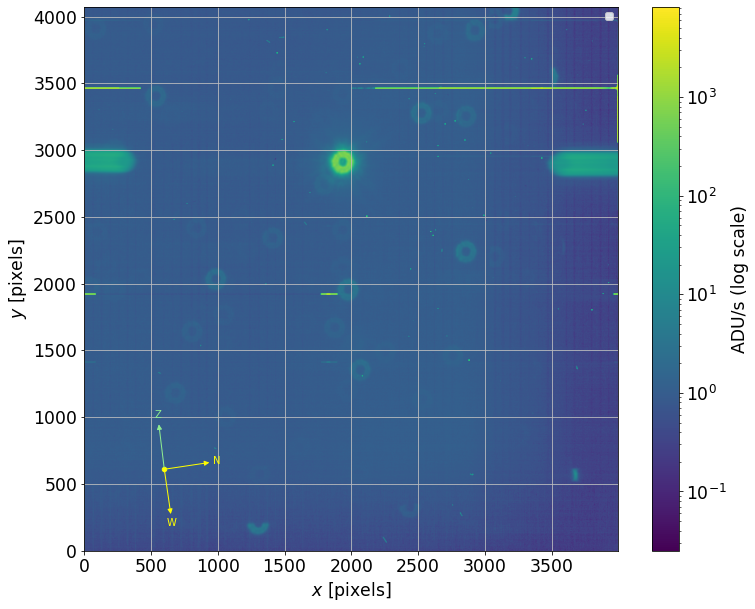

In [30]:
image.plot_image(figsize=(12, 10),scale="log")

In [31]:
#alert False

2021-04-23 10:36:16  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0               c1_0               c0_1       
    ------------------ ------------------ ------------------
    -77.55448844058462 2.1359055835690115 0.8535601444821382
2021-04-23 10:36:17  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 1 iterations because the relative change of cost is below ftol=1.25e-05.


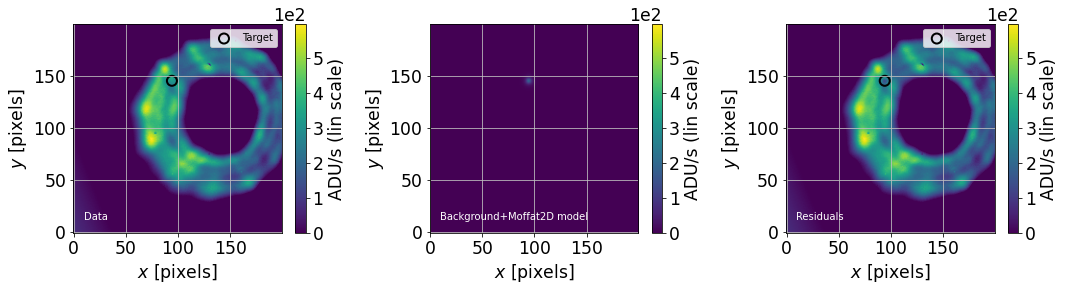

2021-04-23 10:36:18  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 6 iterations because the relative change of cost is below ftol=5e-05.
2021-04-23 10:36:18  Image      find_target_Moffat2D WARNING 
	X=43.93, Y=48.22 target position determination probably wrong: 26.8 pixels from profile detection (41.62, 74.93)


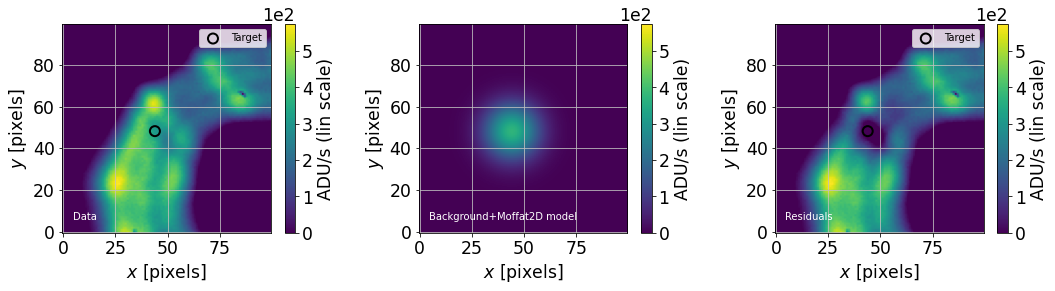

In [32]:
#guess = [2000, 2800]
#guess = [400, 2700] # filename_image=df['file'][37] : Cor_holo4_003_empty_HD60753_2021-02-18_583.fits'
#guess = [300, 2300] #filename_image=df['file'][50] # 'Cor_holo4_003_RG610_HR3439_2021-03-11_167.fits'
#guess = [300, 2500] #filename_image=df['file'][54] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_283.fits'
#guess = [300, 2500] #filename_image=df['file'][55] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_284.fits' BAD image
#guess = [300, 2500]  #filename_image=df['file'][56] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_285.fits' MOVED
#guess = [300, 2500]  #filename_image=df['file'][57] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_286.fits' MOVED
#guess = [300, 2500]  #filename_image=df['file'][58] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_287.fits' MOVED
#guess = [300, 2500]  #filename_image=df['file'][59] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_288.fits' BAD PSF
#guess = [300, 2500]  #filename_image=df['file'][60] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_289.fits' BAD PSF
#guess = [300, 2500]  #filename_image=df['file'][61] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_290.fits' PLANTE
#guess = [300, 2500]  #filename_image=df['file'][62] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_291.fits' BAD PSF
#guess = [300, 2500]  #filename_image=df['file'][63] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_292.fits'  GOOD
#guess = [300, 2500]  #filename_image=df['file'][64] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_293.fits' GOOD
#guess = [300, 2500]  #filename_image=df['file'][65] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_294.fits' GOOD
#guess = [300, 2600]  #filename_image=df['file'][66] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_295.fits' GOOD
#guess = [300, 2600]  #filename_image=df['file'][67] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_296.fits' GOOD
#guess = [300, 2600]  #filename_image=df['file'][68] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_297.fits' BAD PSF
#guess = [300, 2600]  #filename_image=df['file'][69] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_298.fits' BAD PSF
#guess = [300, 2600]  #filename_image=df['file'][70] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_299.fits' BAD PSF
#guess = [300, 2600]  #filename_image=df['file'][71] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_300.fits' BAD PSF
#guess = [300, 2600]  #filename_image=df['file'][72] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_301.fits' PLANTE
#guess = [300, 2600]  #filename_image=df['file'][73] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_302.fits' PLANTE
#guess = [300, 2600]  #filename_image=df['file'][74] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_303.fits' TOO BAD FOCUS
#guess = [300, 2600]  #filename_image=df['file'][75] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_304.fits' TOO BAD FOCUS


#guess = [750, 2700] #filename_image=df['file'][2] # 'Cor_holo4_003_NGC4755_2021-02-17_350.fits' GOOD PSF  
#guess = [750, 2700] #filename_image=df['file'][3] # 'Cor_holo4_003_NGC4755_2021-02-17_351.fits' GOOD PSF 
#guess = [750, 2700] #filename_image=df['file'][4] # 'Cor_holo4_003_NGC4755_2021-02-17_352.fits' GOOD PSF 
#guess = [750, 2700] #filename_image=df['file'][5] # 'Cor_holo4_003_NGC4755_2021-02-17_353.fits' GOOD PSF 
#guess = [750, 2700] #filename_image=df['file'][6] # 'Cor_holo4_003_NGC4755_2021-02-17_354.fits' GOOD PSF 
#guess = [750, 2700] #filename_image=df['file'][7] # 'Cor_holo4_003_NGC4755_2021-02-17_355.fits' GOOD PSF
#guess = [750, 2700] #filename_image=df['file'][8] # 'Cor_holo4_003_NGC4755_2021-02-17_356.fits' GOOD PSF
#guess = [700, 1700] #filename_image=df['file'][9] # 'Cor_holo4_003_NGC4755_2021-02-17_357.fits' GOOD PSF
#guess = [500, 1800] #filename_image=df['file'][10] # 'Cor_holo4_003_NGC4755_2021-02-17_358.fits' GOOD PSF
#guess = [300, 2500] #filename_image=df['file'][11] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_556.fits'  GOOD PSF
#guess = [400, 2600] #filename_image=df['file'][12] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_557.fits'  Defocused, failed
#guess = [350, 2600] #filename_image=df['file'][13] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_558.fits' Defoc, failed
#guess = [1800, 2500] #filename_image=df['file'][14] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_559.fits' Good, but central star
#guess = [400, 2500] #filename_image=df['file'][15] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_560.fits' bad psf, but seems good
#guess = [400, 2500] #filename_image=df['file'][16] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_561.fits' GOOD PSF
#guess = [400, 2500] #filename_image=df['file'][17] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_562.fits' GOOD PSF
#guess = [400, 2500] #filename_image=df['file'][18] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_563.fits' GOOD PSF
#guess = [400, 2500] #filename_image=df['file'][19] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_564.fits' GOOD PSF, FIT BIZARRE

#guess = [400, 2600] #filename_image=df['file'][20] # 'Cor_holo4_003_empty_HD60753_2021-02-18_566.fits' GOOD PSF
#guess = [400, 2600] #filename_image=df['file'][21] # 'Cor_holo4_003_empty_HD60753_2021-02-18_567.fits' GOOD PSF, rec failed order1/2 separated
#guess = [400, 2600] #filename_image=df['file'][22] # 'Cor_holo4_003_empty_HD60753_2021-02-18_568.fits' GOOD PSF, rec , order1/2 separated
#guess = [400, 2600] #filename_image=df['file'][23] # 'Cor_holo4_003_empty_HD60753_2021-02-18_569.fits' GOOD PSF, good rec, order1/2 separated on plate
#guess = [400, 2600] #filename_image=df['file'][24] # 'Cor_holo4_003_empty_HD60753_2021-02-18_570.fits' GOOD PSF, good rec, order1/2 separated on plate
#guess = [400, 2600] #filename_image=df['file'][25] # 'Cor_holo4_003_empty_HD60753_2021-02-18_571.fits' GOOD PSF, failed rec, order1/2 separated on plate
#guess = [400, 2600] #filename_image=df['file'][26] # 'Cor_holo4_003_empty_HD60753_2021-02-18_572.fits' GOOD PSF, good rec, order1/2 separated on plate
#guess = [400, 2600] #filename_image=df['file'][27] # 'Cor_holo4_003_empty_HD60753_2021-02-18_573.fits' BAD PSF, rec, order1/2 separated on plate
#guess = [400, 2700] #filename_image=df['file'][28] # 'Cor_holo4_003_empty_HD60753_2021-02-18_574.fits' BAD PSF, rec, order1/2 separa
#guess = [400, 2700] #filename_image=df['file'][29] # 'Cor_holo4_003_empty_HD60753_2021-02-18_575.fits' BAD PSF, rec, order1/2 separa
#guess = [400, 2700] #filename_image=df['file'][30] # 'Cor_holo4_003_empty_HD60753_2021-02-18_576.fits' BAD PSF, rec, order1/2 separa
#guess = [400, 2700] #filename_image=df['file'][31] # 'Cor_holo4_003_empty_HD60753_2021-02-18_577.fits' BAD PSF, rec, order1/2 separa
#guess = [400, 2700] #filename_image=df['file'][32] # 'Cor_holo4_003_empty_HD60753_2021-02-18_578.fits' BAD PSF, rec, order1/2 separa
#guess = [400, 2700] #filename_image=df['file'][33] # 'Cor_holo4_003_empty_HD60753_2021-02-18_579.fits' BAD PSF, rec, order1/2 separa
#guess = [400, 2700] #filename_image=df['file'][34] # 'Cor_holo4_003_empty_HD60753_2021-02-18_580.fits' BAD PSF, rec, order1/2 separa
#guess= [400, 2700] #filename_image=df['file'][35] # 'Cor_holo4_003_empty_HD60753_2021-02-18_581.fits' BAD PSF, rec, order1/2 separa
#guess= [400, 2700] #filename_image=df['file'][36] # 'Cor_holo4_003_empty_HD60753_2021-02-18_582.fits' BAD PSF, probably bad rec, order1/2 separa
#guess= [400, 2700] #filename_image=df['file'][37] # 'Cor_holo4_003_empty_HD60753_2021-02-18_583.fits' BAD PSF, probably bad rec, order1/2 separa
#guess= [400, 2700] #filename_image=df['file'][38] # 'Cor_holo4_003_empty_HD60753_2021-02-18_584.fits' BAD PSF, probably bad rec, order1/2 separa
#guess= [400, 2700] #filename_image=df['file'][39] # 'Cor_holo4_003_empty_HD60753_2021-02-18_585.fits' BAD PSF, probably good rec, order1/2 separa
#guess= [400, 2700] #filename_image=df['file'][40] # 'Cor_holo4_003_empty_HD60753_2021-02-18_586.fits' BAD PSF, Good rec, order1/2 separa
#guess= [1900, 2900] #filename_image=df['file'][41] # 'Cor_holo4_003_empty_HD60753_2021-02-18_587.fits' BAD PSF, Good rec, order1/2 separa, inutile
guess= [1900, 2900] #filename_image=df['file'][42] # 'Cor_holo4_003_empty_HD60753_2021-02-18_588.fits' BAD FOCUS, Good rec, order1/2 separa, inutile
#guess= [1900, 2900] #filename_image=df['file'][43] # 'Cor_holo4_003_empty_HD60753_2021-02-18_590.fits' NOTHING BAD FOCUS, Good rec, order1/2 separa, inutile
#guess= [1900, 2900] #filename_image=df['file'][44] # '# 'Cor_holo4_003_RG610_HD114449_2021-02-18_591.fits' BAD FOCUS
#guess= [1900, 2900] #filename_image=df['file'][45] # '# 'Cor_holo4_003_RG610_HD114449_2021-02-18_592.fits'

#guess= [1900, 2900] #filename_image=df['file'][46] # 'Cor_holo4_003_RG610_HD114449_2021-02-18_593.fits'   BAD Not focued
#guess= [1900, 2900] #filename_image=df['file'][47] # 'Cor_holo4_003_RG610_HD114449_2021-02-18_594.fits'   BAD Not focued
#guess= [1900, 2900] #filename_image=df['file'][48] # 'Cor_holo4_003_RG610_HR3439_2021-03-11_165.fits'   BAD Not focued
#guess= [200, 2400] #filename_image=df['file'][49] # 'Cor_holo4_003_RG610_HR3439_2021-03-11_166.fits'   bad psf , good reconstruction
#guess= [300, 2300] #filename_image=df['file'][50] # 'Cor_holo4_003_RG610_HR3439_2021-03-11_167.fits'   bad psf , good reconstruction

#guess= [1700, 2300] #filename_image=df['file'][51] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_191.fits'   bad psf + rec OK
#guess= [1700, 2300] #filename_image=df['file'][52] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_192.fits'   bad psf + rec OK
#guess= [1700, 2300] #filename_image=df['file'][53] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_193.fits'   bad psf + rec OK
#guess= [250, 2500] #filename_image=df['file'][54] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_194.fits'   bad focus,very bad psf + bad rec 

#guess= [250, 2500] #filename_image=df['file'][55] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_195.fits'   bad focus,very bad psf + bad rec 
#guess= [250, 2500] #filename_image=df['file'][56] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_196.fits'   bad focus,very bad psf + bad rec 



parameters.VERBOSE = True
parameters.DEBUG = True
x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)

In [33]:
print(x1,y1)

1887.930316849013 2943.222882694131


In [34]:
if x1>100:
    WID=100
else:
    WID=50
    

thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
thumbnail_y=thumbnail.sum(axis=1)
thumbnail_x=thumbnail.sum(axis=0)
xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
kx=kurtosis(thumbnail_x,bias=True,fisher=True)
ky=kurtosis(thumbnail_y,bias=True,fisher=True)
s0=skew(thumbnail,axis=None,bias=True)
sx=skew(thumbnail_x,bias=True)
sy=skew(thumbnail_y,bias=True)
        

In [35]:
shape_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
        r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))

In [36]:
skew_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}'.format(s0),
        r'             : Skx = {:3.3f}'.format(sx),
        r'             : Sky = {:3.3f}'.format(sy)))

In [37]:
kurt_str='\n'.join((
        r'kurtosis : K0 = {:3.3f}'.format(k0),
        r'             : Kx = {:3.3f}'.format(kx),
        r'             : Ky = {:3.3f}'.format(ky)))

In [38]:
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

Text(0.05, 0.4, 'kurtosis : K0 = -0.815\n             : Kx = -1.593\n             : Ky = -1.021')

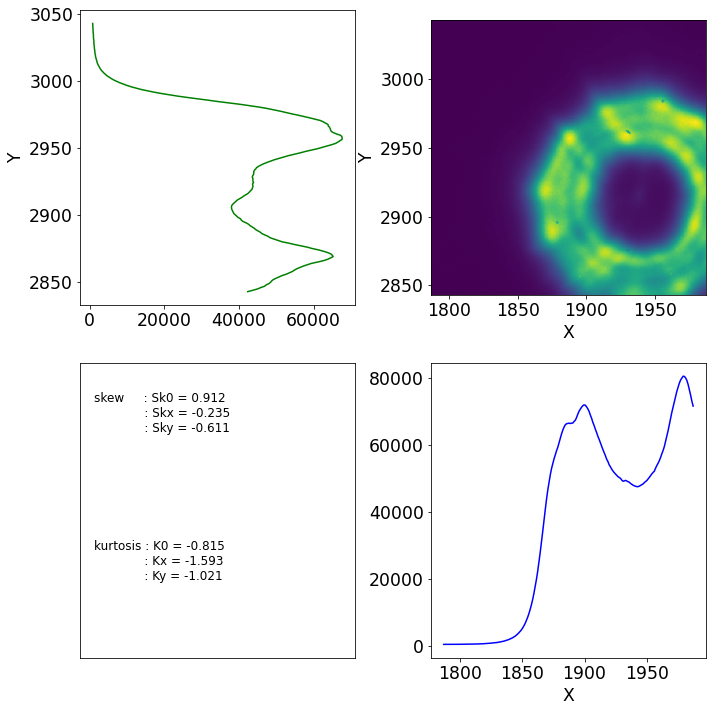

In [39]:
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

ax=fig.add_subplot(222)
ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax=fig.add_subplot(221)
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)
#ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
ax.set_ylabel("Y")

ax=fig.add_subplot(224)
ax.plot(xx,thumbnail_x,"b")
ax.set_xlabel("X")
plt.tight_layout()

ax=fig.add_subplot(223)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
#ax.text(0.05, 0.95, shape_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.4, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)

# Go for spectrum reconstruction

2021-04-23 10:36:20  spectractor.extractor.extractor Spectractor          INFO   
	Start SPECTRACTOR
2021-04-23 10:36:20  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /Users/dagoret/DATA/AuxTelData2021/holo/FlipCleans/Cor_holo4_003_empty_HD60753_2021-02-18_588.fits...
2021-04-23 10:36:20  Image      load_AUXTEL_image    INFO   
	Image loaded


Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /Users/dagoret/.local/lib/python3.7/site-packages/Spectractor-2.1-py3.7.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /Users/dagoret/.local/lib/python3.7/site-packages/Spectractor-2.1-py3.7.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: instrument
x obs_name: AUXTEL	=> parameters.OBS_NAME: AUXTEL	 <class 'str'>
x obs_altitude: 2.66299616375123	=> parameters.OBS_ALTITUDE: 2.66299616375123	 <class 'float'>
x obs_latitude: -30.2446389756252	=> parameters.OBS_LATITUDE: -30.2446389756252	 <class 'float'>
x obs_diameter: 1.20	=> parameters.OBS_DIAMETER: 1.2 m	 <class 'astropy.units.quantity.Quantity'>
x obs_epoch: J2000.0	=> parameters.OBS_EPOCH: J2000.0	 <class 'str'>
x obs_transmission_systematics: 0.005	=> parameters.OBS_TRANSMISSION_SYSTEMATICS: 0.005	 <class 'float'>
x obs_object_type: STAR	=> paramet

2021-04-23 10:36:20  Image      load_image           INFO   
	Loading disperser holo4_003...
2021-04-23 10:36:20  Hologram   load_specs           INFO   
	Load disperser holo4_003:
	from /Users/dagoret/.local/lib/python3.7/site-packages/Spectractor-2.1-py3.7.egg/spectractor/extractor/dispersers/holo4_003
2021-04-23 10:36:20  Hologram   load_specs           INFO   
	Grating characteristics:
	N = 156.00 +/- 1.00 grooves/mm
	Average tilt of -0.3 degrees
2021-04-23 10:36:24  TelescopeTransmission reset_lambda_range   INFO   
	With filter RG610, set parameters.LAMBDA_MIN=563 and parameters.LAMBDA_MAX=1095.
2021-04-23 10:36:24  Star       load                 INFO   
	Simbad:
 MAIN_ID        RA           DEC      ... PM_ERR_MINA_2 PM_ERR_ANGLE_2 Z_VALUE_2
             "h:m:s"       "d:m:s"    ...    mas / yr        deg                
--------- ------------- ------------- ... ------------- -------------- ---------
HD  60753 07 33 27.3190 -50 35 03.311 ...         0.068             90 0.00006

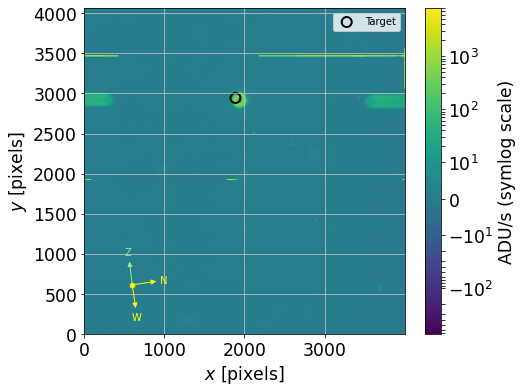

2021-04-23 10:36:29  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the image with guess=[1887.93031685 2943.22288269]...
2021-04-23 10:36:29  spectractor.extractor.images find_target          INFO   
	No WCS /Users/dagoret/DATA/AuxTelData2021/holo/FlipCleans/Cor_holo4_003_empty_HD60753_2021-02-18_588_wcs/Cor_holo4_003_empty_HD60753_2021-02-18_588.wcs available, use 2D fit to find target pixel position.
2021-04-23 10:36:29  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0               c1_0                c0_1       
    ------------------ ------------------ -------------------
    109.50087155369255 2.1576075976042097 -1.3690989157170528
2021-04-23 10:36:29  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 1 iterations because the relative change of cost is below ftol=1.25e-05.


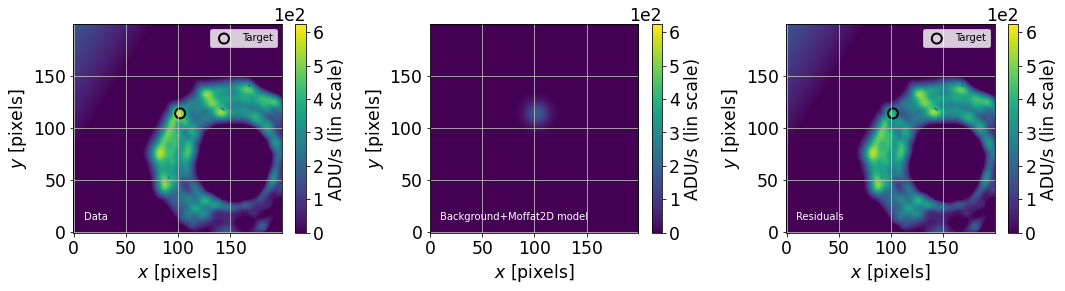

2021-04-23 10:36:30  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 8 iterations because the relative change of cost is below ftol=5e-05.
2021-04-23 10:36:30  Image      find_target_Moffat2D WARNING 
	X=54.24, Y=34.90 target position determination probably wrong: 15.6 pixels from profile detection (49.42, 49.71)


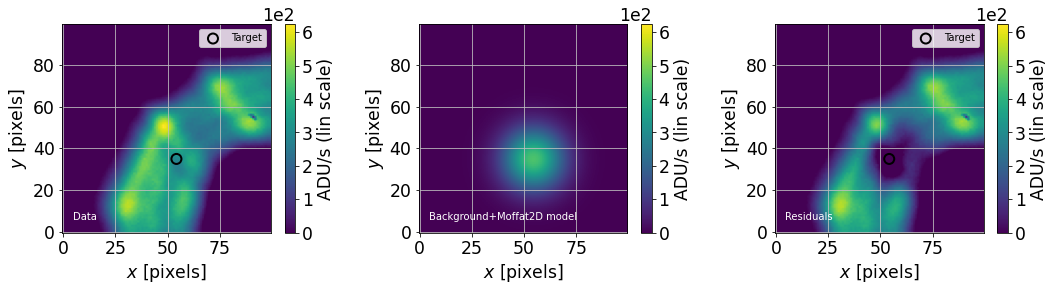

2021-04-23 10:36:31  Image      find_target          INFO   
	X,Y target position in pixels: 1893.242,2940.900


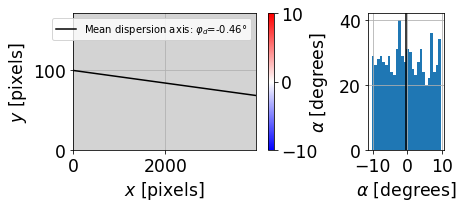

2021-04-23 10:36:32  Image      turn_image           INFO   
	Rotate the image with angle theta=-0.46 degree
/Users/dagoret/.local/lib/python3.7/site-packages/Spectractor-2.1-py3.7.egg/spectractor/tools.py:1713: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  norm = matplotlib.colors.SymLogNorm(vmin=vmin, vmax=vmax, linthresh=10)


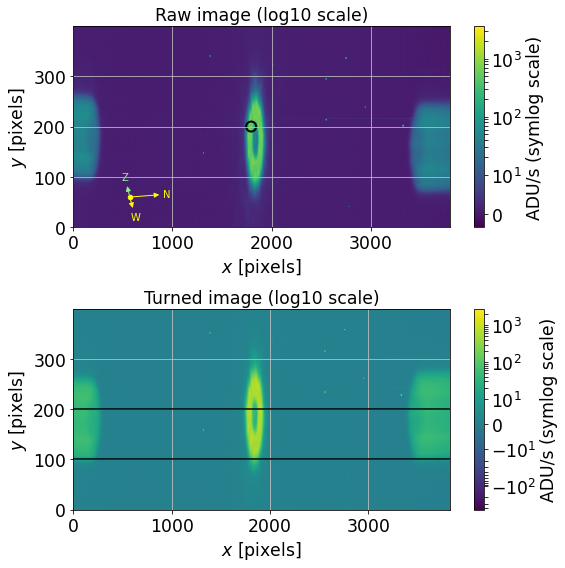

2021-04-23 10:36:44  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the rotated image...
2021-04-23 10:36:44  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0               c1_0                c0_1       
    ------------------ ------------------ -------------------
    223.49184643144244 1.9515554701324214 -0.3456407552645342
2021-04-23 10:36:44  spectractor.fit.fitter gradient_descent     WARNING 
	Step 1: x_c has a null Jacobian; parameter is fixed at its last known current value (35.84212715424173).
2021-04-23 10:36:44  spectractor.fit.fitter gradient_descent     WARNING 
	Step 1: y_c has a null Jacobian; parameter is fixed at its last known current value (82.63170959944276).
2021-04-23 10:36:44  spectractor.fit.fitter gradient_descent     WARNING 
	Step 1: gamma has a null Jacobian; parameter is fixed at its last known current 

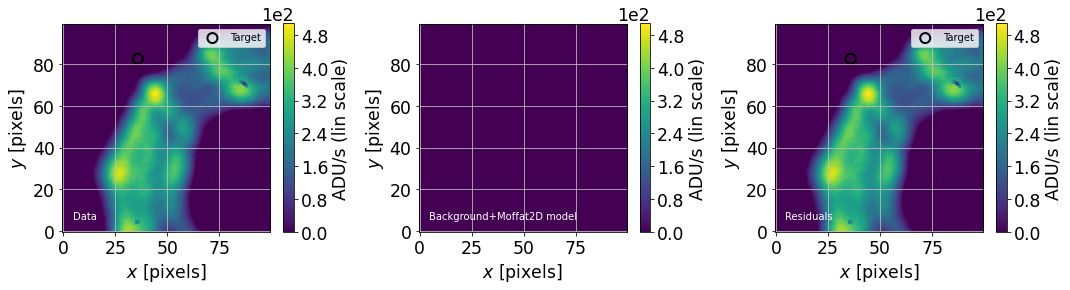

2021-04-23 10:36:45  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: amplitude has a null Jacobian; parameter is fixed at its last known current value (-1.6298145055770874e-09).
2021-04-23 10:36:45  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: x_c has a null Jacobian; parameter is fixed at its last known current value (8.694897926223193).
2021-04-23 10:36:45  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: y_c has a null Jacobian; parameter is fixed at its last known current value (34.24303470659554).
2021-04-23 10:36:45  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: gamma has a null Jacobian; parameter is fixed at its last known current value (100.0).
2021-04-23 10:36:45  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: alpha has a null Jacobian; parameter is fixed at its last known current value (100.0).
2021-04-23 10:36:45  spectractor.fit.fitter gradient_descent     WARNING 
	Gradient descent terminated in 0 

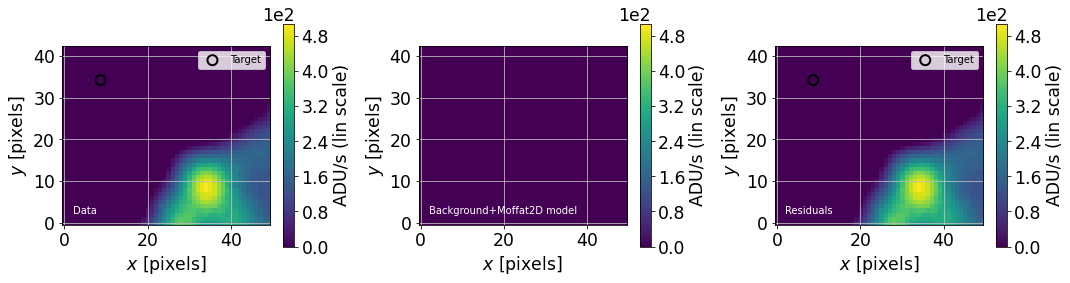

2021-04-23 10:36:46  Image      find_target          INFO   
	X,Y target position in pixels: 1870.695,2997.243
2021-04-23 10:36:46  Spectrum   __init__             INFO   
	Spectrum info copied from image
2021-04-23 10:36:46  TelescopeTransmission reset_lambda_range   INFO   
	With filter RG610, set parameters.LAMBDA_MIN=565.0000000000005 and parameters.LAMBDA_MAX=1089.8000000001198.
2021-04-23 10:36:46  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extracting spectrum from image: spectrum with width 2*20 pixels and background from 140 to 180 pixels
2021-04-23 10:36:47  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop rotated image [3419:3999,2817:3177] (size (580, 360))


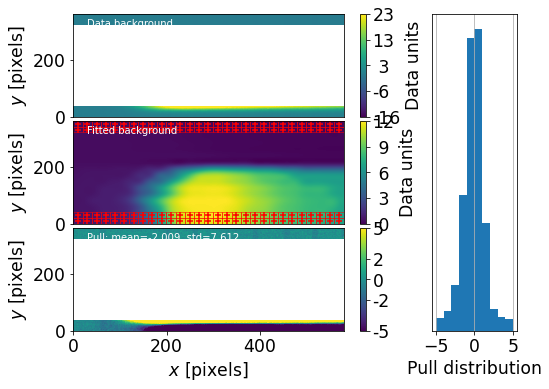

2021-04-23 10:36:48  spectractor.extractor.extractor extract_spectrum_from_image DEBUG  
	Pull distribution of background residuals differs too much from mean=0 and std=1. 
		mean=-2.01; std=7.61
	These value should be smaller in absolute value than 0.5 and 1.3. 
	To do so, parameters.PIXWIDTH_BOXSIZE is divided by 2 from 20 -> 10.


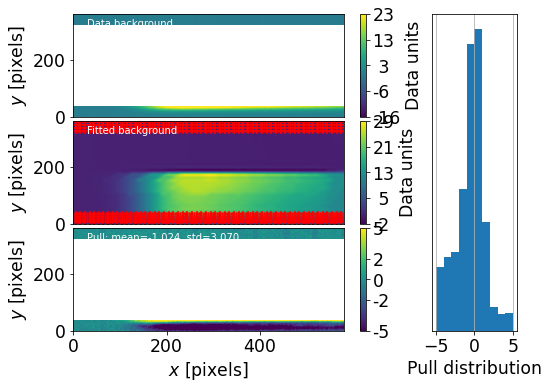

2021-04-23 10:36:52  spectractor.extractor.extractor extract_spectrum_from_image DEBUG  
	Pull distribution of background residuals differs too much from mean=0 and std=1. 
		mean=-1.02; std=3.07
	These value should be smaller in absolute value than 0.5 and 1.3. 
	To do so, parameters.PIXWIDTH_BOXSIZE is divided by 2 from 10 -> 5.


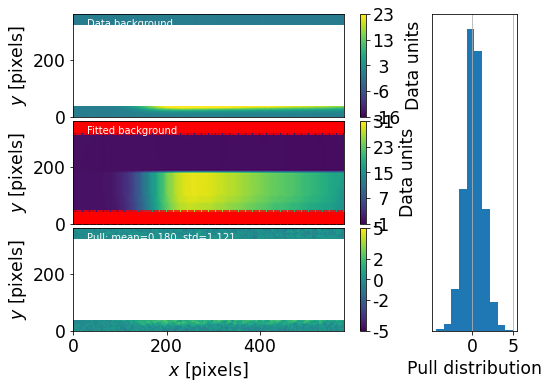

2021-04-23 10:37:01  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Start PSF1D transverse fit...
2021-04-23 10:37:12  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: amplitude has a null Jacobian; parameter is fixed at its last known current value (-3.615747457927549).
2021-04-23 10:37:12  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: y_c has a null Jacobian; parameter is fixed at its last known current value (180.0).
2021-04-23 10:37:12  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: gamma has a null Jacobian; parameter is fixed at its last known current value (3.0).
2021-04-23 10:37:12  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: alpha has a null Jacobian; parameter is fixed at its last known current value (2.0).
2021-04-23 10:37:12  spectractor.fit.fitter gradient_descent     WARNING 
	Gradient descent terminated in 0 iterations because all parameters have null Jacobian.
/Users/dagoret/.local/lib/p

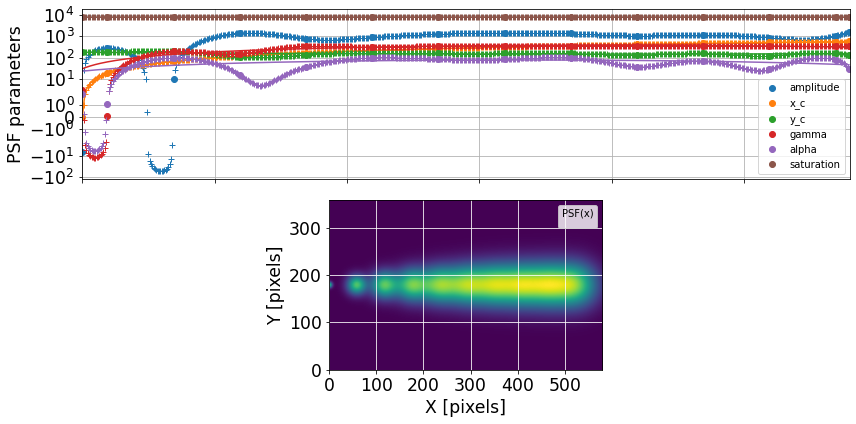

2021-04-23 10:37:15  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: y_c_0 has a null Jacobian; parameter is fixed at its last known current value (-40.57046525027615).
2021-04-23 10:37:15  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: y_c_1 has a null Jacobian; parameter is fixed at its last known current value (22.776069644645116).
2021-04-23 10:37:15  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: y_c_2 has a null Jacobian; parameter is fixed at its last known current value (-28.13104304372976).
2021-04-23 10:37:15  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=1.915e+06 initial chisq_red=82.544
		 Line search: alpha_min=16.3 iter=0 funcalls=12
	Parameter shifts: [-7.75300271e+08  1.08012266e+10  1.15765359e+10 -9.48836833e+02
 -1.11456012e+03  1.47648829e+03]
	New parameters: [-7.75299979e+08  1.08012267e+10  1.15765358e+10 -8.97127475e+02
 -1.07930246e+03  1.41998693e+03]
	Final cost=1.2683e+06 final chi

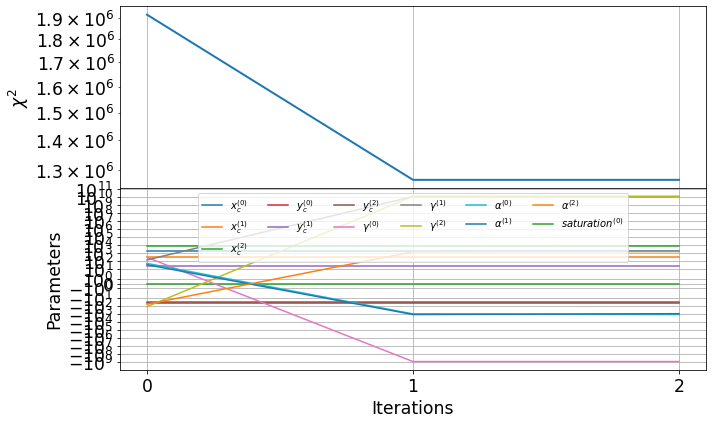

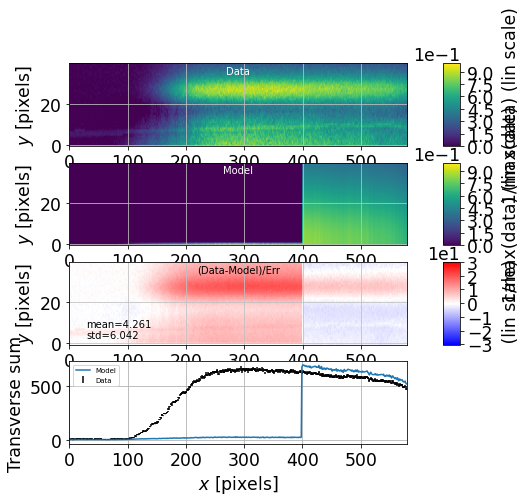

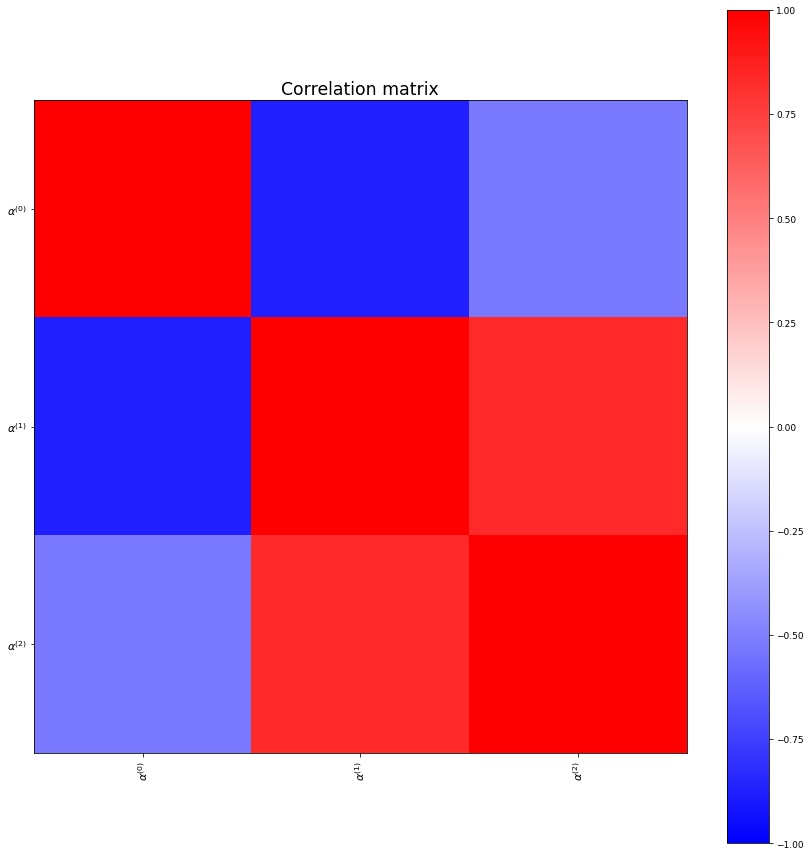

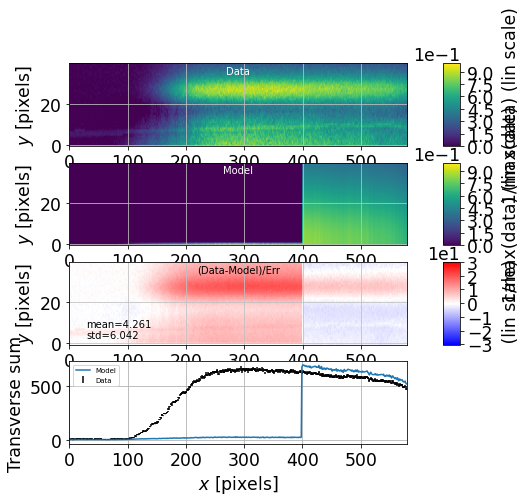

2021-04-23 10:37:22  spectractor.extractor.extractor extract_spectrum_from_image DEBUG  
	Transverse fit table before derotation:
      amplitude        x_c  ...          Dy         Dy_disp_axis
--------------------- ----- ... ------------------- ------------
   2.5385198747281397   0.0 ...  -91.47757793865104          0.0
 0.001861861581935463   1.0 ...  -91.10789420090967          0.0
-0.004463443326663014   2.0 ...  -90.73921741791587          0.0
  0.00920772622181648   3.0 ...  -90.37154758966958          0.0
 0.013878249578051715   4.0 ...  -90.00488471617089          0.0
-0.011310700936152844   5.0 ...  -89.63922879741973          0.0
 -0.00641327231561553   6.0 ...  -89.27457983341614          0.0
0.0027242586351413542   7.0 ...   -88.9109378241601          0.0
 0.010524837866333793   8.0 ...  -88.54830276965161          0.0
 0.009407500558240842   9.0 ...  -88.18667466989066          0.0
                  ...   ... ...                 ...          ...
   1982.2273041222252 569

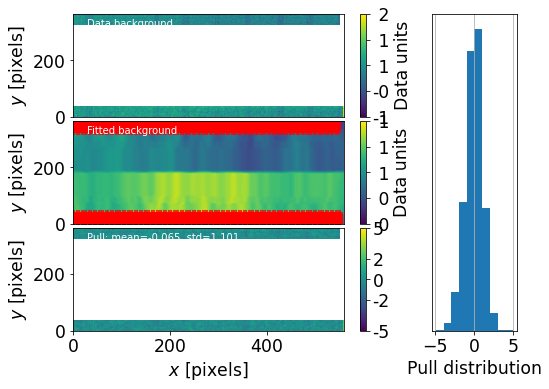

2021-04-23 10:37:31  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Background statistics: mean=0.584 ADU/s, RMS=0.428 ADU/s.
2021-04-23 10:37:31  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop image [3441:4000,2744:3109] (size (559, 365))
	New target position in spectrogram frame: [-1547.7579602532214, 196.8998613726485]


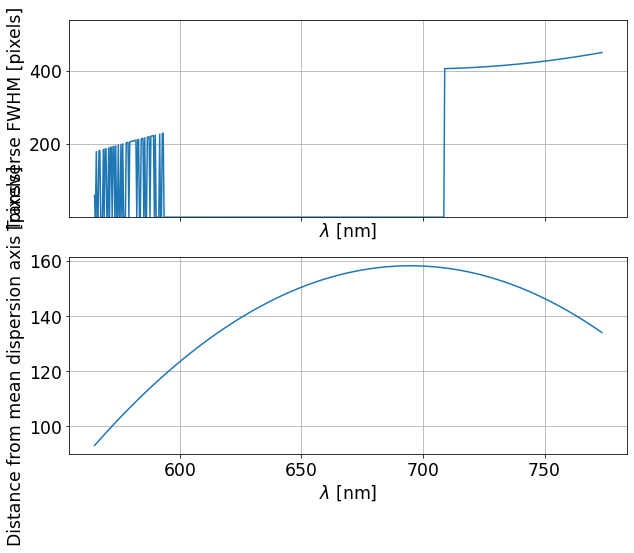

/Users/dagoret/.local/lib/python3.7/site-packages/Spectractor-2.1-py3.7.egg/spectractor/tools.py:1713: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  norm = matplotlib.colors.SymLogNorm(vmin=vmin, vmax=vmax, linthresh=10)


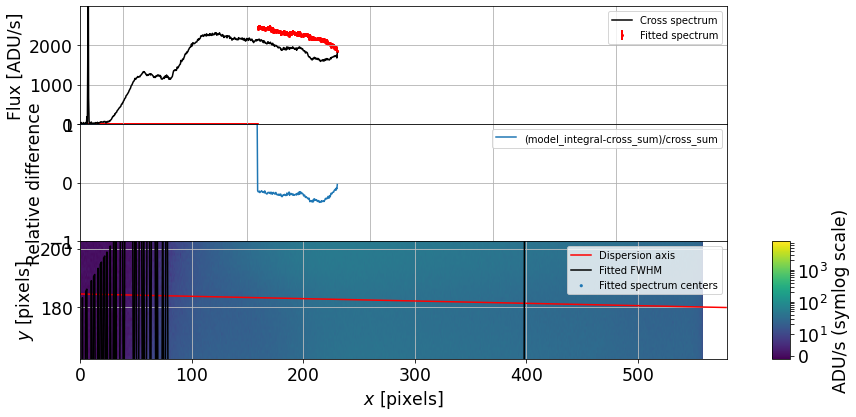

2021-04-23 10:37:33  spectractor.extractor.extractor Spectractor          INFO   
	Calibrating order 1 spectrum...
2021-04-23 10:37:39  Spectrum   calibrate_spectrum   WARNING 
	Minimum chisq is on the edge of the exploration grid.


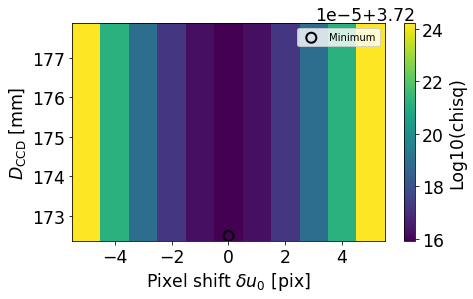

spectrum/calibrate_spectrum::pixel_shift_step= 1.0
spectrum/calibrate_spectrum::parameters.DISTANCE2CCD_ERR= 0.5
spectrum/calibrate_spectrum::error= (0.5, 1.0)
spectrum/calibrate_spectrum::start= [172.4980011   0.       ]


2021-04-23 10:37:42  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: 0.000pix
	D = 172.498 mm (default: DISTANCE2CCD = 175.00 +/- 0.50 mm, -5.0 sigma shift)
2021-04-23 10:37:42  astropy    _showwarning         WARNING VerifyWarning: Card is too long, comment will be truncated.
2021-04-23 10:37:42  Spectrum   save_spectrum        INFO   
	Spectrum saved in ./outputs/Cor_holo4_003_empty_HD60753_2021-02-18_588_spectrum.fits
2021-04-23 10:37:42  Spectrum   save_spectrogram     INFO   
	Spectrogram saved in ./outputs/Cor_holo4_003_empty_HD60753_2021-02-18_588_spectrogram.fits


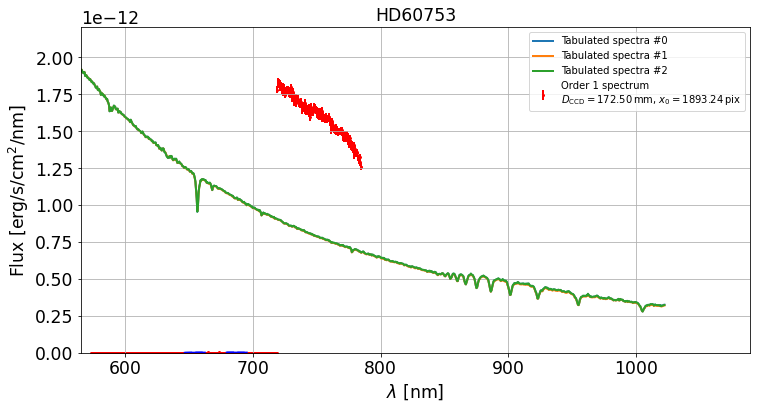

In [40]:
spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)